# Introduction

In [4]:
# Setup
!pip install opencv-python

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:01


2023-04-13 16:04:18.240712: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 16:04:18.336419: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 16:04:18.337637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 16:04:19.921290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Avoid OMM Error
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
# check the GPU
physical_devices

[]

In [8]:
# define the images directory
data_dir = "/tmp/PLD_3_Classes_256"
print(os.listdir(data_dir))

['Training', 'Testing', 'Validation']


In [9]:
# let`s make EDA for the dataset
data_splits = os.listdir(data_dir)
for data_kind in data_splits:
    classes = os.listdir(os.path.join(data_dir,data_kind))
    print(f'*We Process the {data_kind}')
    for class_ in classes:
        path = os.path.join(os.path.join(data_dir,data_kind),class_)
        print(f'  we have a {len(os.listdir(path))} images from class {class_}')
    print('')


*We Process the Training
  we have a 1303 images from class Early_Blight
  we have a 1132 images from class Late_Blight
  we have a 816 images from class Healthy

*We Process the Testing
  we have a 162 images from class Early_Blight
  we have a 141 images from class Late_Blight
  we have a 102 images from class Healthy

*We Process the Validation
  we have a 163 images from class Early_Blight
  we have a 151 images from class Late_Blight
  we have a 102 images from class Healthy



In [10]:
# Filter out Corrupted images

num_skipped = 0
data_splits = os.listdir(data_dir)

for data_kind in data_splits:
    data_kind_path = os.path.join(data_dir,data_kind)
    print(f'*We Process the {data_kind}')
    
    classes = os.listdir(data_kind_path)
    for class_ in classes:
        folder_path = os.path.join(data_kind_path,class_)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path,fname)

            try:
                fobj = open(fpath,"rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)
    print(f"  Deleted {num_skipped} Images for {data_kind}\n")


*We Process the Training
  Deleted 0 Images for Training

*We Process the Testing
  Deleted 0 Images for Testing

*We Process the Validation
  Deleted 0 Images for Validation



# Genrate a Dataset and Visualize

In [11]:
# load data with tf.utils.image_dataset_from_directory
IMAGE_SIZE = (256,256)
BATCH_SIZE = 16
SEED = 42

# make train-testing-validation datasets
def load_data(data_dir):
    data = []
    for class_d in os.listdir(data_dir):
        data.append(
            tf.keras.utils.image_dataset_from_directory(
            os.path.join(data_dir,class_d),
            image_size = IMAGE_SIZE,
            batch_size = BATCH_SIZE,
            seed = SEED)
                   )
    return data
# apllying the Load dataset
test_ds, train_ds, val_ds = load_data(data_dir)


Found 3251 files belonging to 3 classes.
Found 405 files belonging to 3 classes.
Found 416 files belonging to 3 classes.


2023-04-13 16:06:01.540719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3251]
	 [[{{node Placeholder/_4}}]]
2023-04-13 16:06:01.542709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3251]
	 [[{{node Placeholder/_0}}]]


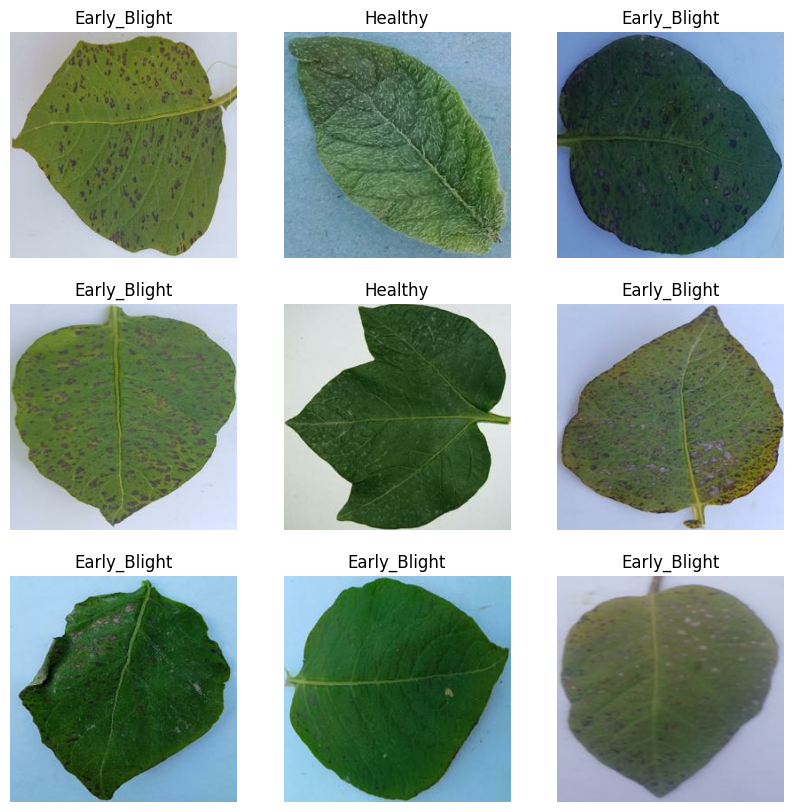

In [12]:
# plot Visualize 
plt.figure(figsize=(10,10))
for image, label in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(train_ds.class_names[label[i]])
        plt.axis("off");
        

## Standardize the data

In [13]:
# standardize values to be in the [0,1] range
normalization_layer = tf.keras.layers.Rescaling(1./255)

# using thr Dataset.map to apply this layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# check pixels after normalization
images_batch, label_batch = next(iter(normalized_ds))
random_image = images_batch[4]
print(f' min value = {np.min(random_image)} , max value =  {np.max(random_image)}')

 min value = 0.011764707043766975 , max value =  1.0


2023-04-13 16:06:25.173758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [405]
	 [[{{node Placeholder/_4}}]]
2023-04-13 16:06:25.175248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [405]
	 [[{{node Placeholder/_4}}]]


# Configure the dataset for performance


In [14]:
# make sure to use buffered prefetching , yield the data without having I/O become bloking
def Configure(dataset):
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# apply the function
train_ds = Configure(train_ds)
val_ds = Configure(val_ds)


# Build a Model

In [17]:
# build a small version of the `Xception Network`

NUM_CLASSES = 3
INPUT_SHAPE = IMAGE_SIZE +(3,)
model = tf.keras.Sequential([
    
    # rescaling and Data augmentation block
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=INPUT_SHAPE),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.Rescaling(1.0/255),
    
    # Conv2D Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Flatten Block
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    
],name = "Mido")


# plot the model
tf.keras.utils.plot_model(model, show_shapes=True)
    

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
# Compile the Model  
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

In [19]:
# Define Callback
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>=0.98):   
            keys = list(logs.keys())
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))
            self.model.stop_training = True
            
# define object from CustomCallback Class
callbacks = CustomCallback()

In [20]:
# training the model
EPOCHS = 50
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs =EPOCHS,
                    callbacks=[callbacks])

Epoch 1/50


2023-04-13 16:07:54.399448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [405]
	 [[{{node Placeholder/_4}}]]
2023-04-13 16:07:54.400848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [405]
	 [[{{node Placeholder/_4}}]]
2023-04-13 16:07:59.066622: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132128768 exceeds 10% of free system memory.
2023-04-13 16:08:01.398263: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132128768 exceeds 10% of free system memory.


 1/26 [>.............................] - ETA: 3:16 - loss: 1.1225 - accuracy: 0.0625

2023-04-13 16:08:02.579757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132128768 exceeds 10% of free system memory.
2023-04-13 16:08:05.333700: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132128768 exceeds 10% of free system memory.


 2/26 [=>............................] - ETA: 1:34 - loss: 1.0604 - accuracy: 0.1875

2023-04-13 16:08:06.488715: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132128768 exceeds 10% of free system memory.


26/26 [==============================] - ETA: 0s - loss: 1.1058 - accuracy: 0.3827

2023-04-13 16:09:21.172880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [416]
	 [[{{node Placeholder/_4}}]]
2023-04-13 16:09:21.173992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [416]
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 108s 4s/step - loss: 1.1058 - accuracy: 0.3827 - val_loss: 1.0877 - val_accuracy: 0.3846
Epoch 2/50
26/26 [==============================] - 104s 4s/step - loss: 1.0687 - accuracy: 0.3259 - val_loss: 1.0488 - val_accuracy: 0.3918
Epoch 3/50
26/26 [==============================] - 103s 4s/step - loss: 1.0808 - accuracy: 0.3975 - val_loss: 1.0360 - val_accuracy: 0.4543
Epoch 4/50
26/26 [==============================] - 124s 5s/step - loss: 1.0517 - accuracy: 0.3704 - val_loss: 1.0065 - val_accuracy: 0.4880
Epoch 5/50
26/26 [==============================] - 103s 4s/step - loss: 1.0331 - accuracy: 0.4395 - val_loss: 0.9850 - val_accuracy: 0.4808
Epoch 6/50
26/26 [==============================] - 120s 5s/step - loss: 0.9984 - accuracy: 0.4543 - val_loss: 0.9663 - val_accuracy: 0.5192
Epoch 7/50
26/26 [==============================] - 120s 5s/step - loss: 0.9727 - accuracy: 0.4790 - val_loss: 0.9475 - val_accuracy: 0.5216
Epoch 8/50
26/26 [======

# Model Evaluation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])



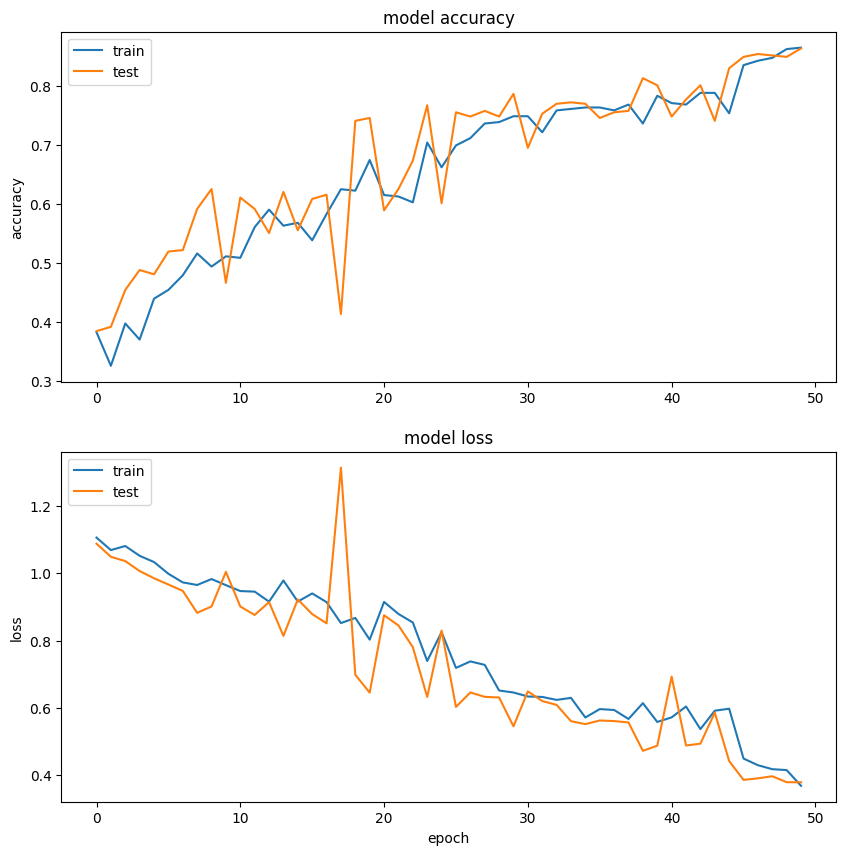

In [21]:
# list all data in history
print(history.history.keys())
print("")
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# evalute model
model.evaluate(test_ds)

26/26 [==============================] - 1s 16ms/step - loss: 0.0524 - accuracy: 0.9784


[0.05241440236568451, 0.9783653616905212]

In [17]:
# To Color The Output
from termcolor import colored

The Real Image was:  {'Early_Blight'} 



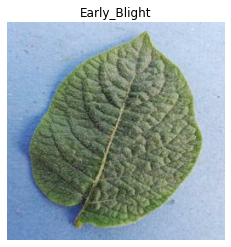


The Model Prediction was: 

(16, 256, 256, 3)

Class From Model Prediction is : {'Early_Blight'}  with confidence = {'99.61 %'}


In [18]:
# ok everythink look nice, let`s check pic manually
for image_batch, label_batch in test_ds.take(1):
    idx = np.random.randint(0,15)
    print(f"The Real Image was: ",colored({test_ds.class_names[label[idx]]}, 'red'),"\n")
    plt.imshow(image_batch[idx].numpy().astype('uint8'))
    plt.title(test_ds.class_names[label[idx]])
    plt.axis("off");
    plt.show()
    
    print(f"\nThe Model Prediction was: \n")
    print(image_batch.shape)
    pred = model.predict(image_batch)
    pred_idx = np.argmax(pred[idx])
    confidence = str(round(100*(np.max(pred[idx])), 2)) + " %"
    print("")
    print("Class From Model Prediction is :",colored({test_ds.class_names[label[pred_idx]]}, 'green')," with confidence =",colored({confidence},'yellow'))

    

In [19]:
# saving the model
model.save('save_model')

2023-01-22 16:09:54.628435: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Convert to ONNX

In [20]:
# # Convert to ONNX using the Python API
# !pip install tf2onnx onnxruntime
# import tf2onnx
# import onnxruntime as rt

# spec = (tf.TensorSpec((None, 256, 256, 3), tf.float32, name="input"),)
# output_path = model.name + ".onnx"

# model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
# output_names = [n.name for n in model_proto.graph.output]

In [21]:
# # Convert to ONNX using the command line

# !python3 -m tf2onnx.convert --opset 13 \
#     --saved-model {os.path.join("","save_model" )} \
#     --output  {os.path.join("save_model", model.name + ".onnx")}

In [22]:
path = os.path.join("/save_model", model.name + ".onnx")
print(path)

/save_model/Mido.onnx
